## Linear Discriminant Analysis (LDA)
- used as feature extraction technique to increase __computational efficiency__ and __reduce degree of overfitting__ due to curse of dimensionality in non-regularized models.
- Where PCA attempt to find the orthogonal component axes of __maximum variance in the dataset__, the __goal__ of __LDA__ is to find the __feature Sub-space that optimizes class separability.__

Following figure summarizes the concept of LDA for a two-class problem samples .
<br>
![lda](lda.png)


A __linear-Discriminant__, as shown on the x-axis (LD1), would seprate the two normal distributed classes well. 
- Althought the exemplary Linear discrimanant on y-axis(LD2) caputures a lot of the variance , but it would fail as a good linear discriminant since it does not capture any of the class-discriminatory information.


#### Assumpiton
- One assumption in LDA is that the data is __normally distributed__.
- Also we assume, that the classes have identical covariance matrices and that the features are statistically independent of each other.

However, if one or more of these assumpitons are (slightly) violated, LDA for dimensionality reduction can still work resasonably well.

Let's briefly summarize the __main steps that are required to perform LDA:__
1. Standardize the d-dimensional dataset(d is the number of features).
2. For ___each class___, comput the _d-dimensonal_ mean vector.
3. Construct the between-class scatter matrix <font style='font-size:16px;font-family: cursive;'> $S_B$ </font>and the within class scatter matrix <font style='font-size:16px;font-family: cursive;'> $S_w$.</font>
4. Compute the eigenvectors and corresponding eigenvalues of the maxtix <font style='font-size:16px;font-family: cursive;'> $S_w^{-1}S_B$.</font>
5. Sort the eigenvalues by decreasing order to rank the corresponding  eigenvectors.
6. Choose the _k_ eigenvector corresponding to the k-largest eigenvalues to contruct _dxk_ dimensional transformation matrix __W__; the eigenvectors are the columns of this matrix.

7. Project the samples onto the new feature subspace using the transformation matrix __W__

#### Computing the Scatter matrices

Each mean vector ___m___ store the mean feature value $ \mu_m$ with respect to the samples of class i:

<center>$m_i = \frac {1}{n_i} \sum^{c}_{x \in D_i}x_m $</center>

<center>$m_i = \begin{bmatrix} \mu_{i,alcohol} \\ \mu_{i,malic acid} \\ . \\ .  \\. \\ \mu_{i, proline} \end{bmatrix} \space \space i
\in \{ 1,2,3 \}$</center>

In [11]:
# Loading and Standardizing the data

import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)

from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[: ,1:].values , df_wine.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

In [12]:
np.unique(y_train)

array([1, 2, 3])

In [13]:
import numpy as np

In [14]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n'%(label, mean_vecs[label-1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



Using the above mean vectors, we can now compute the within-class scatter matrix ___$S_w$___:<br><br>
<center>$S_w = \sum_{i=1}^cS_i$</center>

<br>
<br>
This is calculated by summing up the individual sactter matrices $S_i$ of each individual class i:
<center>$S_i = \sum_{x\in D_i}^c ( x-m_i ) ( x-m_i )^T$</center>

In [18]:
d = 13 # number of features in wine dataset

S_W = np.zeros((d,d))
for label, mv in zip(range(1,4) , mean_vecs):
    class_scatter = np.zeros((d,d))
#     print(label)
    for row in X_train_std[y_train == label]:
#         print(row)
        row, mv = row.reshape(d,1), mv.reshape(d,1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
    
print('Within-class scatter matrix : %sx%s' %(S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix : 13x13


The assmption we are making , when computing scatter matrices is that the class labels in the training set are uniformly distirbuted.
However, print the number of class labels, we can see that this assumption is violated:

In [20]:
print('Class label distribution :%s' %np.bincount(y_train)[1:])

Class label distribution :[41 50 33]


As we see, that training set in not uniformly distributed across class labes. Thus, we want to scale the individual scatter matrices __$S_i$__ , before we sum them up as scatter matrix $S_W$. 
<br>
When we divide the scatter matrices by the number of class-samples _n_, we see that computing the scatter matrixx is in fact the same as computing the covariance matrix $\sum_i$, --- __the covariance matrix is a normalized version of the scatter matrix.__

<center>$ \sum_i = \frac{1}{n_i}S_W = \frac{1}{n_i}\sum_{x\in D_i}^c ( x-m_i ) ( x-m_i )^T$</center>

In [24]:
d = 13 # number of features in wine dataset

S_W = np.zeros((d,d))
for label, mv in zip(range(1,4) , mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
    
print('Scaled Within-class scatter matrix : %sx%s' %(S_W.shape[0], S_W.shape[1]))

Scaled Within-class scatter matrix : 13x13


After computing the scaled within class scatter matrix, we can move on to __compute the between-class scatter matrix $S_B$:__
<center>$S_B = \sum_{x = i}^c n_i( m_i - m ) ( m_i-m )^T$</center>

Here __m__, is the overall mean that is computed, including samples from all classes:

In [27]:
mean_overall = np.mean(X_train_std, axis = 0)
d = 13 # Number of features in wine dataset
S_B = np.zeros((d,d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i +1, :].shape[0]
    mean_vec = mean_vec.reshape(d,1)  #MAKING columns vector
    mean_overall = mean_overall.reshape(d,1)
    S_B += n*((mean_vec - mean_overall).dot((mean_vec - mean_overall).T))
print('Between-class scatter matrix: %sx%s' %(S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


### Selecting linear discriminants for the new feature subspace

The remaining steps of the LDA are similARr to tte the steps of the PCA. However, instead of performing the eigen decomposition on the covariance matrix, we solve the generalized eigenvalue problem of the matrix $S_W^{-1}S_B$:

In [57]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [58]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key = lambda k: k[0], reverse=True)

print('Eigenvalues in descending order :\n')

for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order :

349.617808906
172.76152219
6.04295215732e-14
5.68434188608e-14
3.46719772654e-14
3.46719772654e-14
2.41811010948e-14
2.41811010948e-14
1.47416823371e-14
1.47416823371e-14
4.96504385334e-15
4.48476732166e-15
4.48476732166e-15


<font style="color:red">In LDA, the number of linear discriminant __is at most c-1, where c is the number of class labels, __ since the in-between scatter matrix $S_B$ is the sum of matrices __ with rank 1 or less. __ </font><br>
- We can indeed see that we only have two nonzero eignevalues(the eigenvalues 3-13 are not exactly zero , but this is due to the floating poin arithmetic in NumPy).

- To measure how much of the class-discriminatory information is captured by the linear discriminants (eignevectors), let's plot the linear discriminants by decresaing eigenvalues similar to the the explained variance plot that we created in the PCA section. For simplicity, we will call the content o class-discrimnatory information __discriminability:__

In [59]:
import matplotlib.pyplot as plt
% matplotlib inline

In [60]:
tot = sum(eigen_vals.real)
discr = [(i/tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)


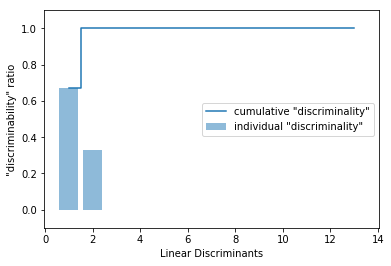

In [61]:
plt.bar(range(1,14), discr, alpha=0.5, align='center', label='individual "discriminality"')
plt.step(range(1,14), cum_discr, where='mid', label='cumulative "discriminality"')
plt.xlabel('Linear Discriminants')
plt.ylabel('"discriminability" ratio')
plt.ylim([-0.1,1.1])
plt.legend(loc='best')
plt.show()

- As we can see in the resulting figure, the first two linear discriminats alone capture 100 percent of the useful information in the Wine traiing datset.

- Let's now stack the tow mos discriminative eigenvectors columns to create the transformation matrix __W__:

In [62]:
eigen_pairs

[(349.61780890599402,
  array([-0.1481+0.j,  0.0908+0.j, -0.0168+0.j,  0.1484+0.j, -0.0163+0.j,
          0.1913+0.j, -0.7338+0.j, -0.0750+0.j,  0.0018+0.j,  0.2940+0.j,
         -0.0328+0.j, -0.3547+0.j, -0.3915+0.j])),
 (172.76152218979396,
  array([-0.4092+0.j, -0.1577+0.j, -0.3537+0.j,  0.3223+0.j, -0.0817+0.j,
          0.0842+0.j,  0.2823+0.j, -0.0102+0.j,  0.0907+0.j, -0.2152+0.j,
          0.2747+0.j, -0.0124+0.j, -0.5958+0.j])),
 (6.0429521573237899e-14,
  array([-0.3320+0.j,  0.2939+0.j,  0.3042+0.j, -0.0605+0.j,  0.0142+0.j,
         -0.5013+0.j,  0.2307+0.j,  0.1236+0.j, -0.0590+0.j, -0.1381+0.j,
         -0.2178+0.j,  0.4074+0.j,  0.3889+0.j])),
 (5.6843418860808015e-14,
  array([ 0.7517+0.j, -0.0834+0.j, -0.2406+0.j,  0.2515+0.j, -0.0586+0.j,
          0.1027+0.j,  0.0109+0.j, -0.0250+0.j,  0.0611+0.j, -0.0726+0.j,
          0.1757+0.j, -0.0943+0.j, -0.4933+0.j])),
 (3.4671977265449034e-14,
  array([-0.2953+0.2571j, -0.0380-0.2804j, -0.0833-0.3669j,  0.0869+0.2037j,
     

In [63]:
W  = np.hstack([eigen_pairs[0][1][:,np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real])

In [64]:
print('Matrix W: \n', W)

Matrix W: 
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


#### Projecting samples onto the new feature space

Using the transformation matrix __W__ that we created in the previous subsection, we can now transform the training dataset by multiplying the matrices:
<center>$X^` = XW$</center>

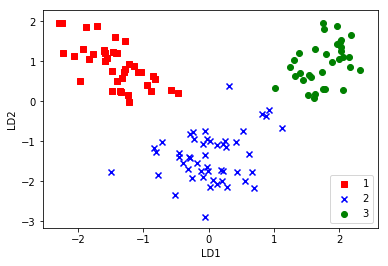

In [65]:
X_train_lda = X_train_std.dot(W)
colors = ['r','b','g']
markers = ['s','x','o']

for l, c,m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l,0], X_train_lda[y_train== l , 1] * (-1),
               c = c, label=l, marker= m)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower right')
plt.show()

## LDA via Scikit-learn



In [71]:
import sys
sys.path.append('/home/amit/Documents/ML/python_ML_RASCHKA/chap2/')

from utilities import plot_decision_regions

In [69]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression


In [67]:
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

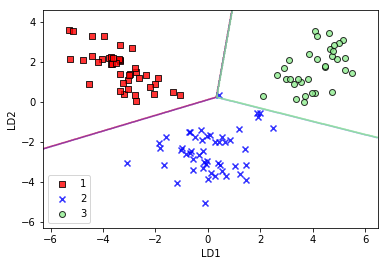

In [72]:
#  Now let's see how logistic regression handles the lower-dimensional training dataset after the LDA transformation:
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower left')
plt.show()

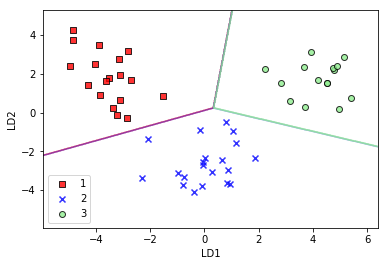

In [74]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc = 'lower left')
plt.show()